## 计算机视觉：图像分类

### 项目介绍：基于Analytics-Zoo Orca on yarn 分布式框架训练图像分类模型
### 1.导入模块，初始化运行环境

In [1]:
import tensorflow as tf
# from zoo.orca import init_orca_context, stop_orca_context
# from zoo.orca.learn.tf2 import Estimator
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

/root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark2, and pyspark is found in: /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)
/root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/util/engine.py:42: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark2, and pyspark is found in: /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, you are recommended to use one source only to avoid conflict. For example, you can unset SPARK_HOME and use p

Prepending /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [2]:
## 更新系统的环境变量
import os
print(os.environ["PATH"])

/root/anaconda3/envs/zoo-tf2.3/bin:/root/anaconda3/bin:/root/anaconda3/bin:/usr/jdk64/java/bin:/usr/hdp/3.0.1.0-187/hadoop/bin:/usr/local/spark2/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


### 2.载入cifar10数据集

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
print("Train datasets shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
image_shape = tuple(train_images.shape[1:])

Train datasets shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)


### 3.数据分析
#### 3.1原始数据可视化

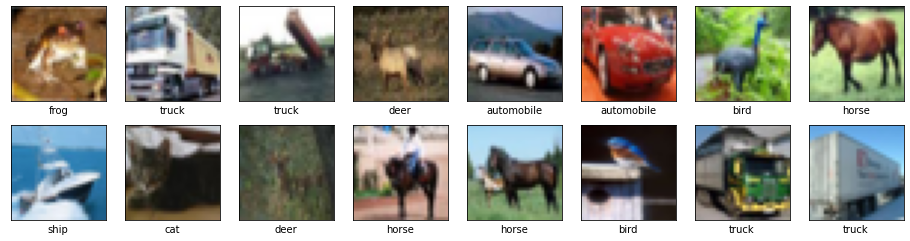

In [5]:
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#### 3.2数据增广以及可视化

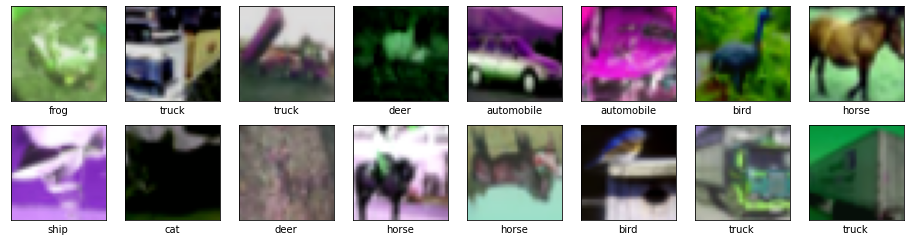

In [6]:
# Tensorflow API进行增广
import numpy as np
def preprocess_image(image, label):
    #Color augmentation
    x = tf.image.random_hue(image, 0.3)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.3)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    #Flip
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    #Random crop
    x = tf.image.random_crop(x,size=[int(image_shape[0] * 0.9), int(image_shape[1] * 0.9), 3])
    x = tf.image.resize(x, [image_shape[0], image_shape[1]])
    return x, label

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=2).batch(1)
iter_dataset = iter(dataset)
plt.figure(figsize=(16,4))
for i in range(16):
    image,label = iter_dataset.get_next()
    image = image.numpy().astype(np.uint8)
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(class_names[label[0][0]])
plt.show()
del dataset

In [7]:
# 自定义方式增广
from imgaug import augmenters as iaa
seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                       shear={"x": (-1, 1), "y": (-1, 1)},
                       scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                       rotate=(-10, 10)
                       ),
            iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30), from_colorspace="RGB"),
            iaa.MultiplyHueAndSaturation(mul_hue=(0.5, 1.5)),
            iaa.Resize({"height": image_shape[0], "width": image_shape[1]})
        ])

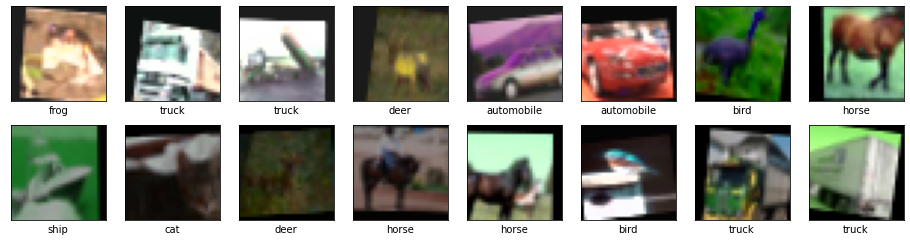

In [8]:
def image_aug(image):
    result = seq(image=image.numpy())
    return result
def preprocess_image(x, y):
    x = tf.py_function(image_aug, [x], tf.float32)
    return x, y

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=2).batch(1)
iter_dataset = iter(dataset)
plt.figure(figsize=(16,4))
for i in range(16):
    image,label = iter_dataset.get_next()
    image = image.numpy().astype(np.uint8)
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(class_names[label[0][0]])
plt.show()
del dataset

### 4.构建数据预处理Pipeline

In [9]:
def train_preprocess(x, y):
    #Color augmentation
    x = tf.image.random_hue(x, 0.3)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.3)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    #Flip
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    #Random crop
    x = tf.image.random_crop(x,size=[int(image_shape[0] * 0.9), int(image_shape[1] * 0.9), 3])
    x = tf.cast(tf.image.resize(x, [image_shape[0], image_shape[1]]), dtype=tf.float32) / 255.0
    return x, y

def image_aug(image):
    result = seq(image=image.numpy())
    return result
def train_preprocess_aug(x, y):
    x = tf.py_function(image_aug, [x], tf.float32)
    x = tf.cast(tf.reshape(x, image_shape), dtype=tf.float32) / 255.0
    return x, y

def test_preprocess(x, y):
    x = tf.cast(tf.reshape(x, image_shape), dtype=tf.float32) / 255.0
    return x, y


def train_data_creator(config):
    global train_images, train_labels
    dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    dataset = dataset.repeat()
    dataset = dataset.map(train_preprocess_aug)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(config["batch_size"])

    return dataset


def val_data_creator(config):
    global test_images, test_labels
    dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    dataset = dataset.repeat()
    dataset = dataset.map(test_preprocess)
    dataset = dataset.batch(config["batch_size"])

    return dataset

### 5.构建模型算法

In [10]:
def vgg16(config):
    from tensorflow.keras import layers
    from tensorflow.keras import regularizers
    model = tf.keras.Sequential()
    weight_decay = 0.0005
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            input_shape=image_shape,
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',
                            padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)
                            ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    return model
def lenet(config):
    model = tf.keras.Sequential(
        [tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                                input_shape=image_shape, padding='same'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                                padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                                padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(500, activation='relu'),
         tf.keras.layers.Dense(256, activation='relu'),
         tf.keras.layers.Dense(84, activation='relu'),
         tf.keras.layers.Dense(10, activation='softmax'),
         ]
    )
    return model

In [11]:
def model_creator(config):
    model = vgg16(config)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 6.定义整个训练函数

In [12]:
def main(max_epoch):
    batch_size = 320
    config = {
        "batch_size": batch_size
    }

    est = Estimator.from_keras(model_creator, config=config, workers_per_node=2)

    history = est.fit(train_data_creator,
                    epochs=max_epoch,
                    steps_per_epoch=60000 // batch_size,
                    validation_data_creator=val_data_creator,
                    validation_steps=10000 // batch_size)
    print(history)
    est.save("/tmp/cifar10_keras.ckpt")
    est.restore("/tmp/cifar10_keras.ckpt")
    stats = est.evaluate(val_data_creator, steps=10000 // batch_size)
    print(stats)
    return history

### 7.基于Orca on yarn模式训练模型

In [ ]:
%%time
import time
cluster_mode = "yarn"
if cluster_mode == "local":
    init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)
elif cluster_mode == "yarn":
    init_orca_context(cluster_mode="yarn-client", num_nodes=4, cores=10,
                      init_ray_on_spark=True, memory="16g", driver_memory="16g",hadoop_user_name='hdfs', hadoop_conf="/etc/hadoop/3.0.1.0-187/0/")

epoch = 5
start_time = time.time()
history = main(epoch)
total_time = time.time() - start_time
print("===================END====================")
print("Per epoch:          %.2f s"%(total_time/epoch))
print("Average throughput: %.4f images/sec"%(60000/(total_time/epoch)))

Initializing orca context
Current pyspark location is : /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/pyspark/__init__.py
Initializing SparkContext for yarn-client mode
Start to pack current python env
Packing has been completed: /tmp/tmpx7t00hsp/python_env.tar.gz
pyspark_submit_args is: --master yarn --deploy-mode client --archives /tmp/tmpx7t00hsp/python_env.tar.gz#python_env --driver-cores 4 --driver-memory 16g --num-executors 4 --executor-cores 10 --executor-memory 16g --driver-class-path /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-SNAPSHOT-jar-with-dependencies.jar:/root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/bigdl/share/lib/bigdl-0.12.1-jar-with-dependencies.jar pyspark-shell
JavaGatewayServer has been successfully launched on executors
Start to launch ray on cluster
Start to launch ray driver on local
Executing command: ray start --address 10.180.210.69:27025 --redis-password 123

2021-01-05 09:07:02,127	WARNING worker.py:792 -- When connecting to an existing cluster, _internal_config must match the cluster's _internal_config.



2021-01-05 09:07:02,033	INFO scripts.py:429 -- Using IP address 10.180.210.122 for this node.
2021-01-05 09:07:02,039	INFO resource_spec.py:212 -- Starting Ray with 261.87 GiB memory available for workers and up to 112.23 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-01-05 09:07:02,039	WARNING services.py:1470 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
2021-01-05 09:07:02,061	INFO scripts.py:438 -- 
Started Ray on this node. If you wish to terminate the processes that have been started, run

    ray stop


{'node_ip_address': '10.180.210.122', 'redis_address': '10.180.210.69:27025', 'ob

(pid=162390, ip=10.180.210.58) 2021-01-05 17:07:04.133694: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: python_env/lib:python_env/lib/python3.6/lib-dynload:
(pid=162390, ip=10.180.210.58) 2021-01-05 17:07:04.133744: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
(pid=162390, ip=10.180.210.58) 2021-01-05 17:07:04.133778: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (master): /proc/driver/nvidia/version does not exist
(pid=162390, ip=10.180.210.58) 2021-01-05 17:07:04.134268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=1

(pid=3949, ip=10.180.210.67) WARNING:tensorflow:AutoGraph could not transform <function train_preprocess_aug at 0x7f2c14756378> and will run it as-is.
(pid=3949, ip=10.180.210.67) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=3949, ip=10.180.210.67) Cause: Unable to locate the source code of <function train_preprocess_aug at 0x7f2c14756378>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=3949, ip=10.180.210.67) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=3949, ip=10.180.210.67) WARNING:tensorflow:AutoGraph could not transform <funct

(pid=166358, ip=10.180.210.69) WARNING:tensorflow:From /hadoop/yarn/local/usercache/hdfs/appcache/application_1609772034079_0008/container_e12_1609772034079_0008_01_000002/python_env/lib/python3.6/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
(pid=166358, ip=10.180.210.69) Instructions for updating:
(pid=166358, ip=10.180.210.69) Use `tf.data.Iterator.get_next_as_optional()` instead.
(pid=3943, ip=10.180.210.67) WARNING:tensorflow:AutoGraph could not transform <function train_preprocess_aug at 0x7f54bc93b378> and will run it as-is.
(pid=3943, ip=10.180.210.67) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=3943, ip=10.180.210.67) Cause: Unable to locate the source code of <function train_preprocess_aug at 0x7f54bc93b378>

(pid=166357, ip=10.180.210.69) WARNING:tensorflow:From /hadoop/yarn/local/usercache/hdfs/appcache/application_1609772034079_0008/container_e12_1609772034079_0008_01_000002/python_env/lib/python3.6/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
(pid=166357, ip=10.180.210.69) Instructions for updating:
(pid=166357, ip=10.180.210.69) Use `tf.data.Iterator.get_next_as_optional()` instead.
(pid=162511, ip=10.180.210.58) WARNING:tensorflow:AutoGraph could not transform <function train_preprocess_aug at 0x7f42db68a400> and will run it as-is.
(pid=162511, ip=10.180.210.58) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=162511, ip=10.180.210.58) Cause: Unable to locate the source code of <function train_preprocess_aug at 0x7f42db6

(pid=162514, ip=10.180.210.58) WARNING:tensorflow:AutoGraph could not transform <function train_preprocess_aug at 0x7f838e871400> and will run it as-is.
(pid=162514, ip=10.180.210.58) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=162514, ip=10.180.210.58) Cause: Unable to locate the source code of <function train_preprocess_aug at 0x7f838e871400>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=162514, ip=10.180.210.58) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=162397, ip=10.180.210.58) WARNING:tensorflow:From /hadoop/yarn/local/us

123/187 [==================>...........] - ETA: 2:05 - loss: 3.6532 - accuracy: 0.2164


186/187 [============================>.] - ETA: 1s - loss: 3.2796 - accuracy: 0.2422
(pid=3943, ip=10.180.210.67) 2021-01-05 17:13:53.548818: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:521] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(pid=3943, ip=10.180.210.67) op: "TensorSliceDataset"
(pid=3943, ip=10.180.210.67) input: "Placeholder/_0"
(pid=3943, ip=10.180.210.67) input: "Placeholder/_1"
(pid=3943, ip=10.180.210.67) attr {
(pid=3943, ip=10.180.210.67)   key: "Toutput_types"
(pid=3943, ip=10.180.210.67)   value {
(pid=3943, ip=10.180.210.67)     list {
(pid=3943, ip=10.180.210.67)       type: DT_UINT8
(pid=3943, ip=10.180.210.67)       type: DT_UINT8
(pid=3943, ip=10.180.210.67)     }
(pid=3943, ip=10.180.210.67)   }
(pid=3943, ip=10.180.210.67) }
(pid=3943, ip=10.180.210.67) attr {
(pid=3943, ip=10

(pid=162397, ip=10.180.210.58) 2021-01-05 17:13:41.421165: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:521] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(pid=162397, ip=10.180.210.58) op: "TensorSliceDataset"
(pid=162397, ip=10.180.210.58) input: "Placeholder/_0"
(pid=162397, ip=10.180.210.58) input: "Placeholder/_1"
(pid=162397, ip=10.180.210.58) attr {
(pid=162397, ip=10.180.210.58)   key: "Toutput_types"
(pid=162397, ip=10.180.210.58)   value {
(pid=162397, ip=10.180.210.58)     list {
(pid=162397, ip=10.180.210.58)       type: DT_UINT8
(pid=162397, ip=10.180.210.58)       type: DT_UINT8
(pid=162397, ip=10.180.210.58)     }
(pid=162397, ip=10.180.210.58)   }
(pid=162397, ip=10.180.210.58) }
(pid=162397, ip=10.180.210.58) attr {
(pid=162397, ip=10.180.210.58)   key: "output_shapes"
(pid=162397, ip=10.